In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 50
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn

## Load in `.csv` file

In [2]:
df = pd.read_csv('data/extracted/crime-data-from-2010-to-present.csv')

In [ ]:
df.head()

In [ ]:
df.shape

## Converting `date occured` to time series index

In [3]:
# removing empty time stamp from Date Reported and Date Ocurred
df["Date Reported"] = df["Date Reported"].str.replace('T00:00:00', '')
df["Date Occurred"] = df["Date Occurred"].str.replace('T00:00:00', '')

In [4]:
# setting 'date occured' column as datetime object
df['Date Occurred'] = pd.to_datetime(df['Date Occurred'], format= '%Y-%m-%d')

In [5]:
df = df.set_index('Date Occurred').sort_index()

In [ ]:
# checking that it all worked
df.head(3)

## Data Cleaning
Now that we have the dataframe converted to a format for time series analysis, we can do basic data cleaning steps.

In [ ]:
# checking for null values
df.isna().sum()

In [6]:
# dropping columns with a majority of missing values
df = df.drop(axis=1, columns=['MO Codes', 
                              'Weapon Used Code', 
                              'Weapon Description', 
                              'Crime Code 1',
                              'Crime Code 2', 
                              'Crime Code 3', 
                              'Crime Code 4', 
                              'Cross Street'])

In [ ]:
demo_features = ['Victim Age', 'Victim Sex', 'Victim Descent']

In [ ]:
df.isna().sum()

In [ ]:
# now we just have to deal with the remaining null values...

In [ ]:
df.info()

In [ ]:
# df['Date Reported'] = pd.to_datetime(df['Date Reported'], format= '%Y-%m-%d')
df.loc[df['Date Reported'] == '1022019-01-01']

In [ ]:
# checking for all values that are ***2019-01-01
unknown = []
for i in range(len(df['Date Reported'])): 
    if len(df['Date Reported'][i])==13:
        unknown.append(df['Date Reported'][i])
len(unknown)


In [ ]:
#replacing all ***2019-01-01 with 2019-01-01
for i in range(len(df['Date Reported'])): 
    if len(df['Date Reported'][i])==13:
        df['Date Reported'] = '2019-01-01'

In [ ]:
#converting date reported variable to datetime format
df['Date Reported'] = pd.to_datetime(df['Date Reported'], format= '%Y-%m-%d')

In [7]:
df['Premise Code'].fillna(0, inplace = True)
df['Premise Description'].fillna('UNKNOWN', inplace = True)
df['Status Code'].fillna('UNK', inplace = True)

# David

In [ ]:
df.isna().sum()

In [ ]:
# let's change H, N, and - to X for Unknown/Other
df['Victim Sex'].value_counts()

In [ ]:
# need to strip whitespace from column name and break out lat/lon data
df['Location '][0]

In [ ]:
df.head(2)

In [8]:
df['data_points'] = df.index.value_counts()

In [9]:
crime_series = df['data_points']

In [10]:
crime_series.dtype

dtype('int64')

In [11]:
crime_series.head()

Date Occurred
2010-01-01    2222
2010-01-01    2222
2010-01-01    2222
2010-01-01    2222
2010-01-01    2222
Name: data_points, dtype: int64

In [ ]:
def plot_series(series):
    plt.figure(figsize=(12,6))
    plt.plot(crime_series)
    plt.ylabel('Crimes per day in LA', fontsize=15)
    
    for year in range(2010,2021):
        plt.axvline(datetime(year,1,1), linestyle='--', alpha=0.5)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(crime_series);

In [ ]:
# plot_series(crime_series)

# Normalize Data

In [ ]:
mean, std = crime_series.mean(), crime_series.std()

In [ ]:
print(mean)
print(std)

In [ ]:
crime_series = (crime_series - mean) / std

In [ ]:
crime_series

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(crime_series);

# Differencing

In [ ]:
crime_series = crime_series.diff()

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(crime_series);

In [ ]:
crime_series.tail()

# Reduce Volatility

In [ ]:
annual_volatility = crime_series.groupby(crime_series.index.year).std()

In [ ]:
annual_volatility

# Reevaluate with Dickey Fuller Test

## EDA

Essentially the variables can be grouped to 
* When the crime occurred - given by date and time
* When the crime was reported - Date
* what was the crime - crime code and crime description
* Who was the victim - Victim sex, age and descent
* What weapon was involved - weapon code and description
* Where the crime took place - given by location, address, cross street, premise code and description

In [ ]:
df.data_points['2010-01-01':'2017-12-31']

In [ ]:
df.groupby('Date Occurred').sum()

# Data Visuals / EDA

In [ ]:
clean_df = pd.read_pickle('data/pickled/cleaned_df.pkl')

In [ ]:
clean_df.head(2)

In [4]:
### USING df FROM ABOVE, NOT clean_df

s = pd.to_datetime(df['Date Occurred'], format= '%Y-%m-%d')
df = s.groupby(s.dt.floor('d')).size().reset_index(name='count')
print (df)

     Date Occurred  count
0       2010-01-01   2222
1       2010-01-02    533
2       2010-01-03    539
3       2010-01-04    558
4       2010-01-05    547
...            ...    ...
3455    2019-06-18    497
3456    2019-06-19    534
3457    2019-06-20    459
3458    2019-06-21    505
3459    2019-06-22    498

[3460 rows x 2 columns]


In [5]:
df.head()

,Date Occurred,count
0,2010-01-01,2222
1,2010-01-02,533
2,2010-01-03,539
3,2010-01-04,558
4,2010-01-05,547


In [ ]:
# clean_df['data_points'] = clean_df.index.value_counts()
# crime_series = clean_df['data_points']
# crime_series.dtype

In [6]:
df.set_index('Date Occurred', inplace=True)

In [7]:
df.head()

,count
Date Occurred,
2010-01-01,2222
2010-01-02,533
2010-01-03,539
2010-01-04,558
2010-01-05,547


In [23]:
mean, std = df['count'].mean(), df['count'].std()
print(mean)
print(std)

576.0864161849711
89.54755562592328


In [24]:
df['count'] = (df['count'] - mean) / std

In [ ]:
df.head()

/Users/davidbruce/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


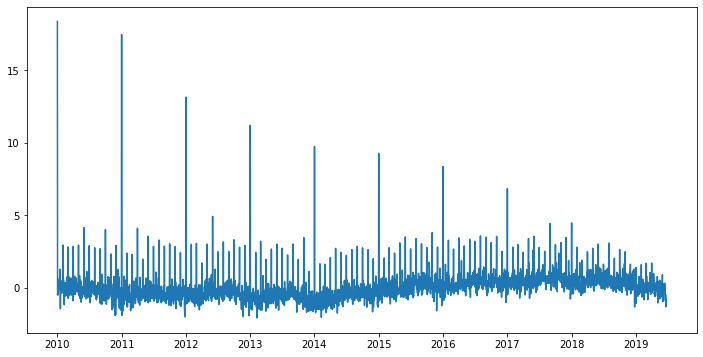

In [25]:
plt.figure(figsize=(12,6))
plt.plot(df);

In [18]:
df.set_index('Date Occurred', inplace=True)

In [19]:
df.head()

,count
Date Occurred,
2010-01-01,2222
2010-01-02,533
2010-01-03,539
2010-01-04,558
2010-01-05,547


In [ ]:
df = df['2010-01-01':'2019-01-01']

In [8]:
# Use pandas grouper to group values using annual frequency
year_groups = df.groupby(pd.Grouper(freq ='A'))

In [ ]:
next(iter(year_groups))

In [9]:
# Create a new DataFrame and store yearly values in columns 
crime_annual = pd.DataFrame()

for yr, group in year_groups:
    crime_annual[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
crime_annual.plot(figsize = (13,8), subplots=True, legend=True);

ValueError: Length of values does not match length of index

In [ ]:
df.tail()

# Run from here
did you import the proper packages?

In [10]:
df = pd.read_csv('data/extracted/crime-data-from-2010-to-present.csv')

In [11]:
# removing empty time stamp from Date Reported and Date Ocurred
df["Date Reported"] = df["Date Reported"].str.replace('T00:00:00', '')
df["Date Occurred"] = df["Date Occurred"].str.replace('T00:00:00', '')

In [12]:
s = pd.to_datetime(df['Date Occurred'], format= '%Y-%m-%d')
df = s.groupby(s.dt.floor('d')).size().reset_index(name='count')
print (df)

     Date Occurred  count
0       2010-01-01   2222
1       2010-01-02    533
2       2010-01-03    539
3       2010-01-04    558
4       2010-01-05    547
...            ...    ...
3455    2019-06-18    497
3456    2019-06-19    534
3457    2019-06-20    459
3458    2019-06-21    505
3459    2019-06-22    498

[3460 rows x 2 columns]


In [13]:
df.set_index('Date Occurred', inplace=True)

In [14]:
df.head()

,count
Date Occurred,
2010-01-01,2222
2010-01-02,533
2010-01-03,539
2010-01-04,558
2010-01-05,547


In [15]:
crime_monthly = df.resample('MS')

In [16]:
month_mean = crime_monthly.mean()

In [21]:
month_mean.head()

,count
Date Occurred,
2010-01-01,624.935484
2010-02-01,571.392857
2010-03-01,584.096774
2010-04-01,591.600000
2010-05-01,570.935484


In [56]:
year_groups = month_mean.groupby(pd.Grouper(freq ='A'))

In [57]:
monthly_annual = pd.DataFrame()

for yr, group in year_groups:
    monthly_annual[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
monthly_annual.plot(figsize = (13,8), subplots=True, legend=True);

ValueError: Length of values does not match length of index

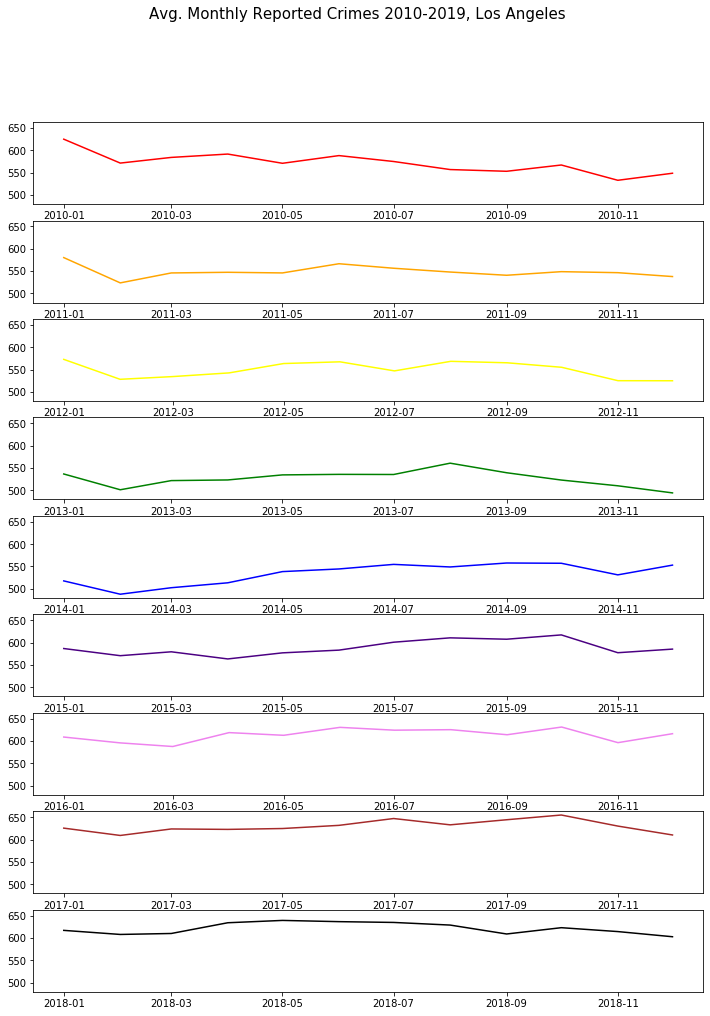

In [55]:
fig, ax = plt.subplots(9, sharey=True, figsize=(12,16))
fig.suptitle('Avg. Monthly Reported Crimes 2010-2019, Los Angeles', fontsize=15)
ax[0].plot(month_mean[:12], color='red')
ax[1].plot(month_mean[12:24], color='orange')
ax[2].plot(month_mean[24:36], color='yellow')
ax[3].plot(month_mean[36:48], color='green')
ax[4].plot(month_mean[48:60], color='blue')
ax[5].plot(month_mean[60:72], color='indigo')
ax[6].plot(month_mean[72:84], color='violet')
ax[7].plot(month_mean[84:96], color= 'brown')
ax[8].plot(month_mean[96:108], color='black');

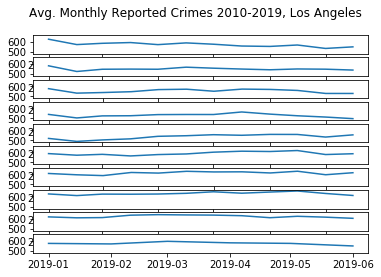

In [43]:
fig, ax = plt.subplots(10, sharey=True)
fig.suptitle('Avg. Monthly Reported Crimes 2010-2019, Los Angeles')
ax[0].plot(month_mean[:12])
ax[1].plot(month_mean[12:24])
ax[2].plot(month_mean[24:36])
ax[3].plot(month_mean[36:48])
ax[4].plot(month_mean[48:60])
ax[5].plot(month_mean[60:72])
ax[6].plot(month_mean[72:84])
ax[7].plot(month_mean[84:96])
ax[8].plot(month_mean[96:108]);
ax[9].plot(month_mean[108:115]);